# Can I get H-1B Visa?

## This is the notebook has the possibility to fortune tell your H-1B Application. There are three parts for this notebook

1. statistics: It contains some statistic about the ratio of H-1B Application and top rank job-tyle for applicant
2. data tansformation: function to transform categorical data to numerical data
3. predictive model: randomforest is implemented here to predict the 

In [81]:
import os
import seaborn as sns
import sklearn as sl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

from cat_data import dummyEncode, plot_cat_info
from misc import uni_wage,generate_list
#plt.style.use('ggplot')
%matplotlib inline 

In [3]:
H1B_data = pd.read_csv('enigma-h1b.csv')

In [56]:
H1B_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519504 entries, 0 to 519503
Data columns (total 36 columns):
lca_case_number                   519504 non-null object
status                            519504 non-null object
lca_case_submit                   519504 non-null object
decision_date                     519504 non-null object
visa_class                        519504 non-null object
lca_case_employment_start_date    519500 non-null object
lca_case_employment_end_date      519499 non-null object
lca_case_employer_name            519476 non-null object
lca_case_employer_address         519462 non-null object
lca_case_employer_city            519477 non-null object
lca_case_employer_state           519458 non-null object
lca_case_employer_postal_code     519463 non-null object
lca_case_soc_code                 519455 non-null object
lca_case_soc_name                 515233 non-null object
lca_case_job_title                519497 non-null object
lca_case_wage_rate_from           

In [5]:
H1B_data.columns.values

array(['lca_case_number', 'status', 'lca_case_submit', 'decision_date',
       'visa_class', 'lca_case_employment_start_date',
       'lca_case_employment_end_date', 'lca_case_employer_name',
       'lca_case_employer_address', 'lca_case_employer_city',
       'lca_case_employer_state', 'lca_case_employer_postal_code',
       'lca_case_soc_code', 'lca_case_soc_name', 'lca_case_job_title',
       'lca_case_wage_rate_from', 'lca_case_wage_rate_to',
       'lca_case_wage_rate_unit', 'full_time_pos', 'total_workers',
       'lca_case_workloc1_city', 'lca_case_workloc1_state', 'pw_1',
       'pw_unit_1', 'pw_source_1', 'other_wage_source_1',
       'yr_source_pub_1', 'lca_case_workloc2_city',
       'lca_case_workloc2_state', 'pw_2', 'pw_unit_2', 'pw_source_2',
       'other_wage_source_2', 'yr_source_pub_2', 'lca_case_naics_code',
       'serialid'], dtype=object)

In [63]:
H1B_data = H1B_data[H1B_data["visa_class"] =="H-1B"]

### Base rate of REJECTED is low and so is withdrawn .

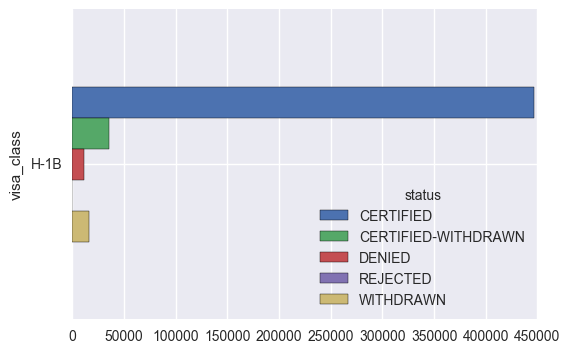

In [49]:
status = plot_cat_info(dfcat,'visa_class', 'status',False)

### Top 5 SOC name is highly related to computer programming

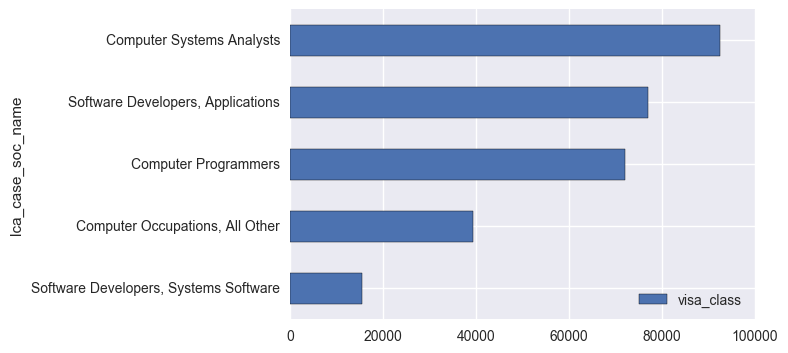

In [50]:
soc_name = plot_cat_info(dfcat,'visa_class', 'lca_case_soc_name',True)

### Analyst and engineers are one of the top applications

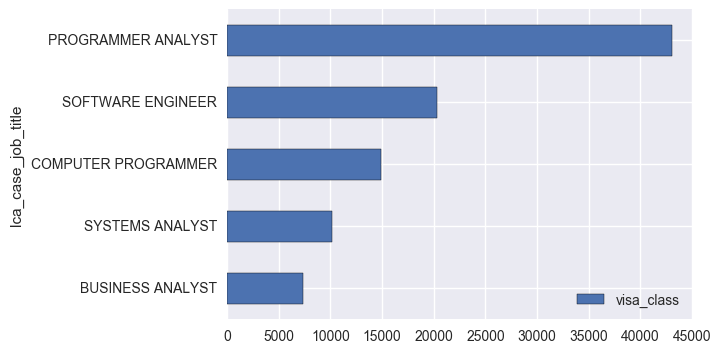

In [51]:
job_title = plot_cat_info(dfcat,'visa_class', 'lca_case_job_title',True)

In [111]:
dfcat = H1B_data[['lca_case_employer_name',
       'lca_case_employer_address', 'lca_case_employer_city',
       'lca_case_employer_state', 'lca_case_employer_postal_code',
       'lca_case_soc_code', 'lca_case_soc_name', 'lca_case_job_title',
       'lca_case_wage_rate_unit', 'full_time_pos', 
        'lca_case_workloc1_city', 'lca_case_workloc1_state']]

In [112]:
#Auto encodes any dataframe column of type category or object.
def dummyEncode(df):
        columnsToEncode = list(df.select_dtypes(include=['category','object']))
        le = LabelEncoder()
        for feature in columnsToEncode:
            try:
                df[feature] = le.fit_transform(df[feature])
            except:
                print('Error encoding '+feature)
        return df


dfcat_dummy = dummyEncode(dfcat)

/Users/Henrilin28/.pyenv/versions/2.7.8/envs/virtual_2.7/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [115]:
data = pd.concat([dfcat_dummy,H1B_data[['lca_case_wage_rate_from', 'lca_case_wage_rate_to', 'total_workers','status']]],axis=1)

In [116]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 508676 entries, 0 to 508675
Data columns (total 16 columns):
lca_case_employer_name           508676 non-null int64
lca_case_employer_address        508676 non-null int64
lca_case_employer_city           508676 non-null int64
lca_case_employer_state          508676 non-null int64
lca_case_employer_postal_code    508676 non-null int64
lca_case_soc_code                508676 non-null int64
lca_case_soc_name                508676 non-null int64
lca_case_job_title               508676 non-null int64
lca_case_wage_rate_unit          508676 non-null int64
full_time_pos                    508676 non-null int64
lca_case_workloc1_city           508676 non-null int64
lca_case_workloc1_state          508676 non-null int64
lca_case_wage_rate_from          508641 non-null float64
lca_case_wage_rate_to            100405 non-null float64
total_workers                    508673 non-null float64
status                           508676 non-null object
dt

In [117]:
data['is_train'] = np.random.uniform(0, 1, len(data)) <= .75

y,_ = pd.factorize(data['status'])

In [ ]:
train, test = data[data['is_train']==True], data[data['is_train']==False]

idx = ['is_train',"status"]
features = [i for j, i in enumerate(list(data.columns.values)) if i not in idx]
clf = RandomForestClassifier(n_jobs=2)
y, _ = pd.factorize(train['status'])
clf.fit(train[features], y)

preds = data.status[clf.predict(test[features])]
pd.crosstab(test['status'], preds, rownames=['actual'], colnames=['preds'])